In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_colwidth', 120)
import pickle
import warnings
warnings.simplefilter(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost.sklearn import XGBClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

The estimators that will be assessed in this jupyter notebook are:
KNeighborsClassifier, RandomForestClassifier, XGBClassifier

In [3]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'
X_train = pd.read_csv(os.path.join(project_path, r'data\X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(project_path, r'data\y_train.csv'), index_col=0, names=['Survived'])
X_test = pd.read_csv(os.path.join(project_path, r'data\X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(project_path, r'data\y_test.csv'), index_col=0, names=['Survived'])

In [7]:
with open(os.path.join(project_path, r'data\kn_selected_features.txt'), "rb") as f:
      kn_selected_features = pickle.load(f)
        
with open(os.path.join(project_path, r'data\rf_selected_features.txt'), "rb") as f:
      rf_selected_features = pickle.load(f)
        
with open(os.path.join(project_path, r'data\xgb_selected_features.txt'), "rb") as f:
      xgb_selected_features = pickle.load(f)

In [8]:
kn_selected_features = [X_train.columns.get_loc(c) for c in kn_selected_features if c in X_train]
rf_selected_features = [X_train.columns.get_loc(c) for c in rf_selected_features if c in X_train]
xgb_selected_features = [X_train.columns.get_loc(c) for c in xgb_selected_features if c in X_train]


In [9]:
pca = PCA()
pca.fit(X_train.iloc[:,kn_selected_features])
pca.explained_variance_ratio_.cumsum()

array([0.1762492 , 0.33717471, 0.45512407, 0.56834077, 0.67151626,
       0.76901807, 0.84500176, 0.91421679, 0.97163899, 1.        ])

In [10]:
pca = PCA()
pca.fit(X_train.iloc[:,rf_selected_features])
pca.explained_variance_ratio_.cumsum()

array([0.31869228, 0.52595028, 0.65644485, 0.78570944, 0.89718458,
       0.97255182, 1.        ])

In [11]:
pca = PCA()
pca.fit(X_train.iloc[:,xgb_selected_features])
pca.explained_variance_ratio_.cumsum()

array([0.27896375, 0.44754683, 0.59324905, 0.70647281, 0.80970975,
       0.899887  , 0.973744  , 1.        ])

In [12]:
class ItemsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys: list):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, dataframe):
        return np.array(dataframe)[:,self.keys]

In [15]:
pipe_kn = Pipeline([('select_items', ItemsSelector(keys=en_selected_features)),
                  #  ('pca', PCA(n_components=7)),
                   ('model', KNeighborsClassifier())
])

pipe_rf = Pipeline([('select_items', ItemsSelector(keys=rf_selected_features)),
                  #  ('pca', PCA(n_components=7)),
                       ('model', RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1))
])

pipe_xgb = Pipeline([('select_items', ItemsSelector(keys=xgb_selected_features)),
                   #  ('pca', PCA(n_components=7)),
                       ('model', XGBClassifier(random_state=1, n_estimators=200))
])

In [25]:
grid_params_kn = {'model__n_neighbors': [5, 10, 15]
}

grid_params_rf = {'model__max_depth':[3, 5, 6, 7, 10, 12]    
}

grid_params_xgb = {'model__learning_rate':[0.001, 0.01, 0.05, 0.1],
                   'model__max_depth':[3, 5, 7, 10, 12] 
                 }

In [26]:
models_names = ['KNeighbors', 'RandomForest', 'XGB']
models = [pipe_kn, pipe_rf, pipe_xgb]
grid_params = [grid_params_kn, grid_params_rf, grid_params_xgb]

In [28]:
models_res = []
for model_name, model, grid_param in zip(models_names, models, grid_params):
    params = ParameterGrid(grid_param)
    for param in params:
        model.set_params(**param)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        balanced_accuracy = balanced_accuracy_score(y_test, pred)
        models_res.append({'MODEL_NAME': model_name, 'PARAMS': param, 'ACCURACY': accuracy, 'BAL_ACCURACY': balanced_accuracy})
models_res = pd.DataFrame(models_res)[['MODEL_NAME','PARAMS','ACCURACY','BAL_ACCURACY']].sort_values('ACCURACY',ascending=False).reset_index(drop=True)


In [29]:
models_res

,MODEL_NAME,PARAMS,ACCURACY,BAL_ACCURACY
0,XGB,"{'model__learning_rate': 0.01, 'model__max_depth': 12}",0.8101,0.7799
1,XGB,"{'model__learning_rate': 0.001, 'model__max_depth': 7}",0.8101,0.7842
2,XGB,"{'model__learning_rate': 0.1, 'model__max_depth': 5}",0.8045,0.7752
3,XGB,"{'model__learning_rate': 0.01, 'model__max_depth': 10}",0.8045,0.7731
4,XGB,"{'model__learning_rate': 0.1, 'model__max_depth': 3}",0.8045,0.7773
5,XGB,"{'model__learning_rate': 0.05, 'model__max_depth': 7}",0.8045,0.7752
6,XGB,"{'model__learning_rate': 0.001, 'model__max_depth': 10}",0.7989,0.7684
7,XGB,"{'model__learning_rate': 0.001, 'model__max_depth': 12}",0.7989,0.7684
8,XGB,"{'model__learning_rate': 0.01, 'model__max_depth': 7}",0.7989,0.7684
9,XGB,"{'model__learning_rate': 0.05, 'model__max_depth': 5}",0.7933,0.7594


XGB, accuracy: 0.810
[[100   6]
 [ 28  45]]


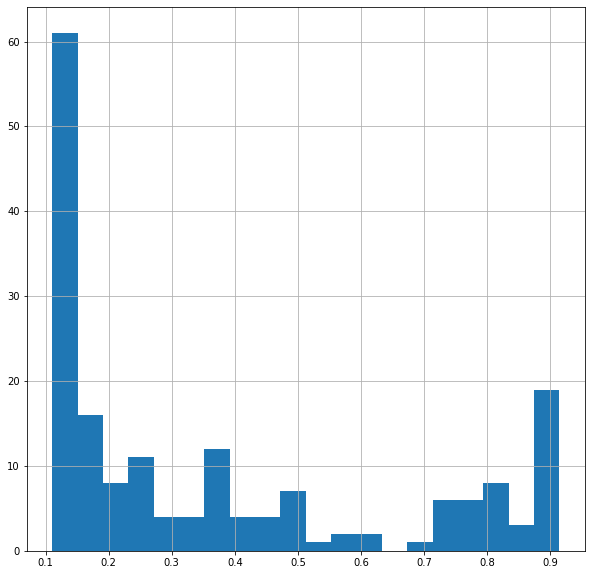

XGB, accuracy: 0.810
[[98  8]
 [26 47]]


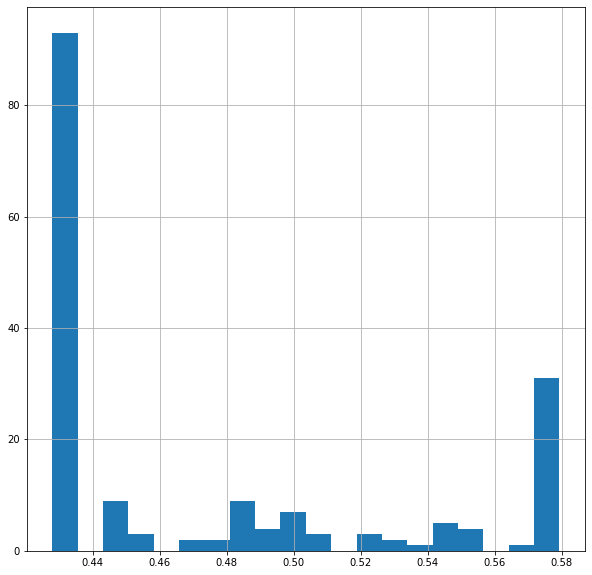

XGB, accuracy: 0.804
[[99  7]
 [28 45]]


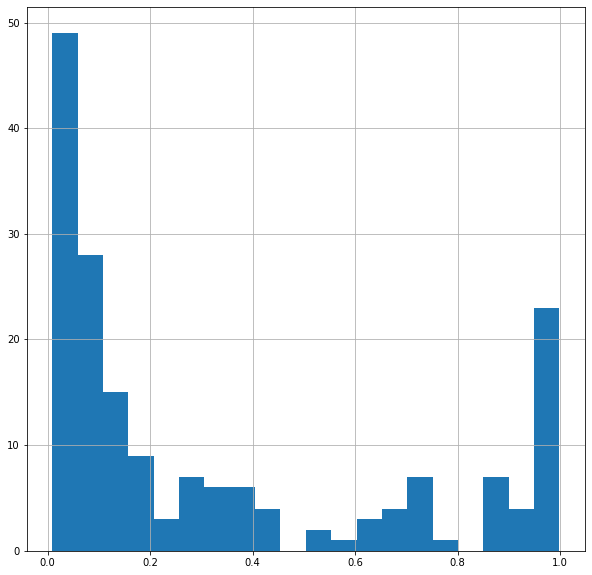

In [48]:
for idx, row in models_res.iloc[:3,:].iterrows():
    model_name = row['MODEL_NAME']
    models_idx = models_names.index(model_name)
    model = models[models_idx].set_params(**row['PARAMS'])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = pd.DataFrame(model.predict_proba(X_test), index=X_test.index, columns = ['PRED_0','PRED_1'])
    accuracy = accuracy_score(y_test, pred)
    print(f"{model_name}, accuracy: {accuracy:0.3f}")
    print(confusion_matrix(y_test, pred))
    plt.figure(figsize=(10,10))
    pred_proba['PRED_1'].hist(bins=20)
    plt.show()

In [56]:
models_to_vote = []

for idx, row in models_res.iloc[:3,:].iterrows():
    model_name = row['MODEL_NAME']
    models_idx = models_names.index(model_name)
    model = models[models_idx].set_params(**row['PARAMS'])
    model.fit(X_train, y_train)
    models_to_vote.append(model)
    
vote = EnsembleVoteClassifier(clfs=models_to_vote, voting='soft')
grid_param = {'weights': [[1, 1, 1], [1, 1, 2], [2, 1, 1], [1, 2, 1]]}

voting_models_res = []
params = ParameterGrid(grid_param)
for param in params:
    vote.set_params(**param)
    vote.fit(X_train, y_train)
    pred = vote.predict(X_test)
    pred = [[p] for p in pred]
    accuracy = accuracy_score(y_test, pred)
    balanced_accuracy = balanced_accuracy_score(y_test, pred)
    voting_models_res.append({'MODEL_NAME': model_name, 'PARAMS': param, 'ACCURACY': accuracy, 'BAL_ACCURACY': balanced_accuracy})
voting_models_res = pd.DataFrame(voting_models_res)[['MODEL_NAME','PARAMS','ACCURACY','BAL_ACCURACY']].sort_values('ACCURACY',ascending=False).reset_index(drop=True)


In [57]:
voting_models_res

,MODEL_NAME,PARAMS,ACCURACY,BAL_ACCURACY
0,XGB,"{'weights': [1, 1, 1]}",0.8045,0.7752
1,XGB,"{'weights': [1, 1, 2]}",0.8045,0.7752
2,XGB,"{'weights': [2, 1, 1]}",0.8045,0.7752
3,XGB,"{'weights': [1, 2, 1]}",0.8045,0.7752


XGB, accuracy: 0.804
[[99  7]
 [28 45]]


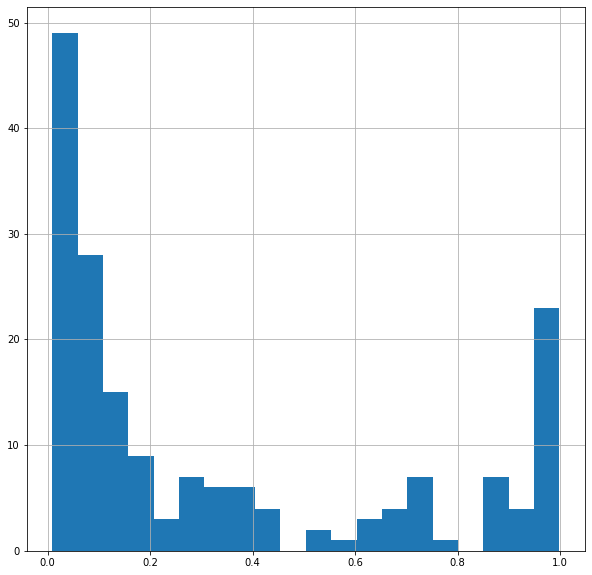

In [58]:

vote.set_params(**voting_models_res['PARAMS'].loc[0])
vote.fit(X_train, y_train)
pred = vote.predict(X_test)

pred_proba = pd.DataFrame(model.predict_proba(X_test), index=X_test.index, columns = ['PRED_0','PRED_1'])
accuracy = accuracy_score(y_test, pred)
print(f"{model_name}, accuracy: {accuracy:0.3f}")
print(confusion_matrix(y_test, pred))
plt.figure(figsize=(10,10))
pred_proba['PRED_1'].hist(bins=20)
plt.show()

In [59]:
test = pd.read_csv(os.path.join(project_path, r'data\test_lb.csv')).set_index('PassengerId')

In [60]:
pred_lb = vote.predict(test)
pred_lb = pd.DataFrame(pred_lb, columns = ['Survived'], index=test.index).reset_index()
pred_lb.to_csv(os.path.join(project_path, r'data\submission.csv'),index=False)